In [24]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

import base64
import cv2
import supervision as sv
from random import randint

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import sobel, gaussian
from skimage.segmentation import active_contour


# Point (Pupil) Initializing

Using Hough transform and Active contour

In [94]:
def preprocess_img(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"
    img = cv2.GaussianBlur(img, (7, 7), 0)
    return img



def HoughTransform_Pupil(img):
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,dp=1.2,minDist=50,
        param1=50,param2=30,minRadius=20,maxRadius=70)
 
    if circles is None:
        return
    circles = np.uint16(np.around(circles))
    return circles

def ActiveContour_pupil(img, init_circle):
    
    s = np.linspace(0,2*np.pi,400)
    r = init_circle[0] + init_circle[2]*np.cos(s)*1.1
    c = init_circle[1] + init_circle[2]*np.sin(s)*1.1
    init = np.array([r,c]).T
    edge = cv2.Canny(img,50,150) #sobel
    
    
    snake = active_contour(
        edge,
        init,
        alpha=0.015,
        beta=10,
        gamma=0.001)
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
    ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.imshow(edge)
    
    return snake


def average_pixel_value(img, circle):
    img = np.ascontiguousarray(img, dtype=np.uint8)
    # Extract circle parameters
    (x, y, r) = circle.astype(np.int32)
    
    
    
    # Ensure circle is within image bounds
    if x - r >= 0 and x + r < img.shape[1] and y - r >= 0 and y + r < img.shape[0]:
        # Create a mask for the circular region
        roi = img[y - r: y + r, x - r: x + r]

        width, height = roi.shape[:2]
        mask = np.zeros((width, height, 3), roi.dtype)
        cv2.circle(mask, (int(width / 2), int(height / 2)), r, (255, 255, 255), -1)
        

        masked_image = cv2.bitwise_and(roi, mask)
        total_pixels = np.sum(mask) / 255  # Total pixels in the circle
        average_value = np.sum(masked_image) / total_pixels
        
        return average_value
    else:
        return 255
    
    

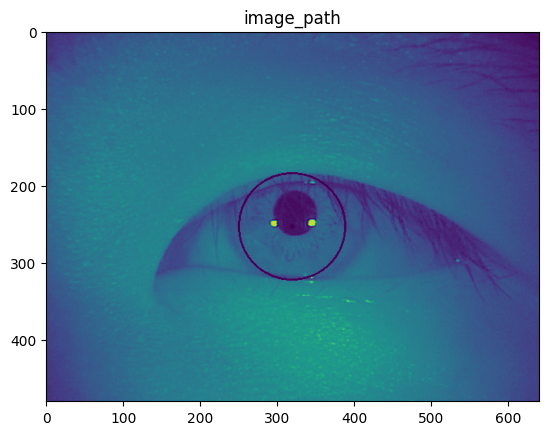

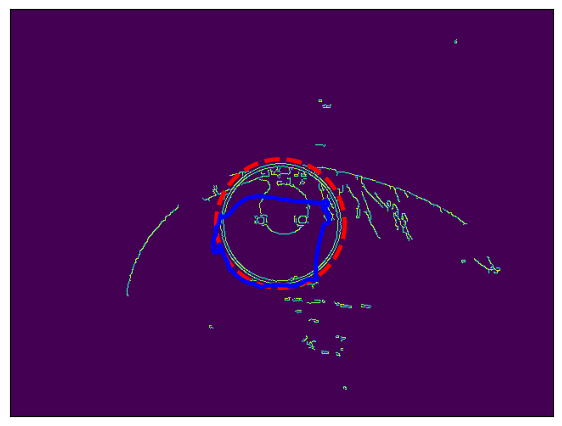

In [68]:
HOME_PATH = os.getcwd()
image_path = os.path.join(HOME_PATH, "images", "CASIA-Iris-Thousand","162","R","S5162R02.jpg")
pathList = randIrisPath("CASIA-Iris-Thousand",20)
raw_img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
preprocessed_img = preprocess_img(image_path)


circles=HoughTransform_Pupil(preprocessed_img)
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(raw_img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(raw_img,(i[0],i[1]),2,(0,0,255),3)
 
plt.imshow(raw_img)
plt.title('image_path')
plt.show()

for c in circles[0,:]:
    snake = ActiveContour_pupil(raw_img,c)
    

plt.show()
    

nan


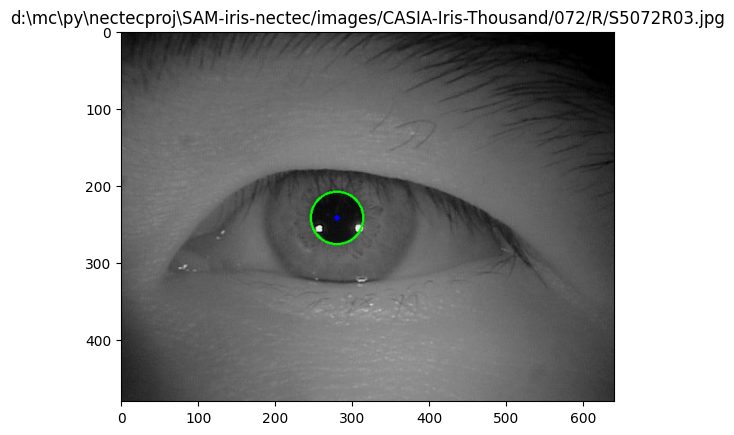

nan
nan
nan
nan
nan
nan


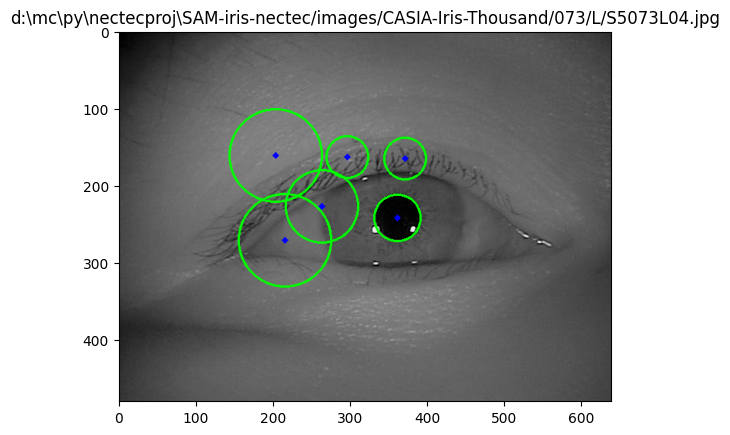

nan
nan
nan
nan


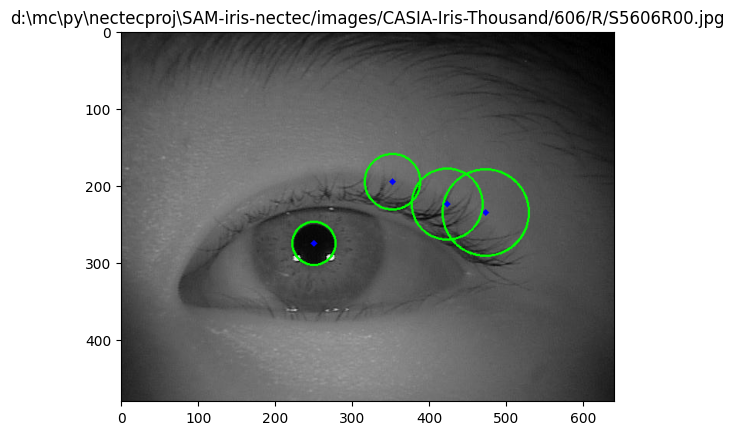

nan
nan
nan
nan


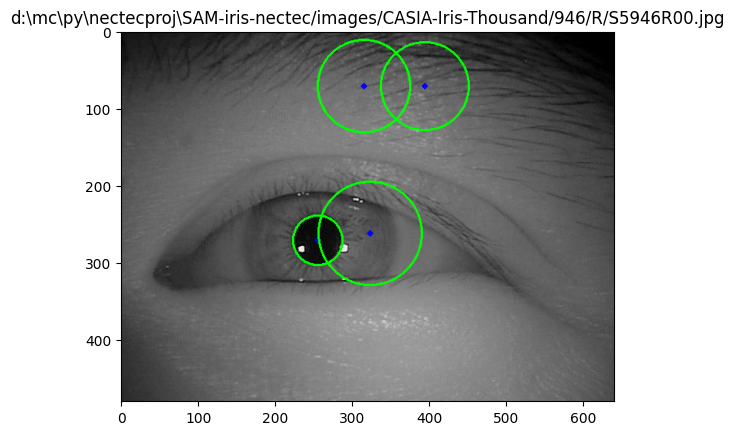

nan


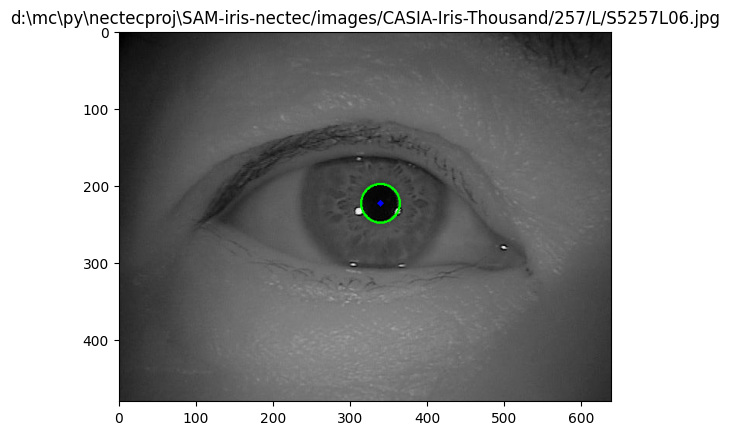

nan
nan


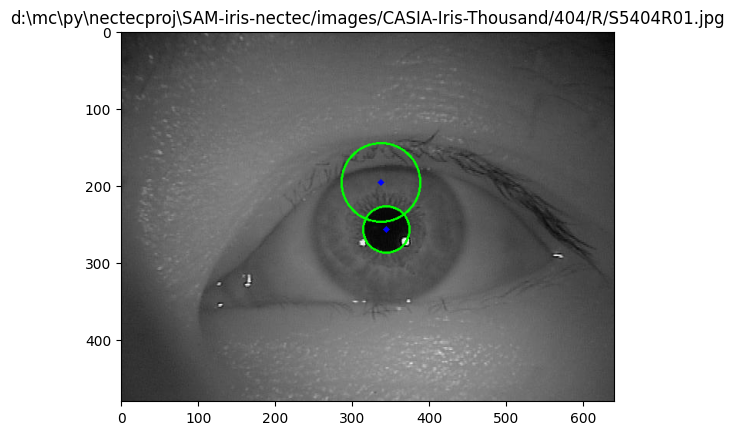

nan
nan


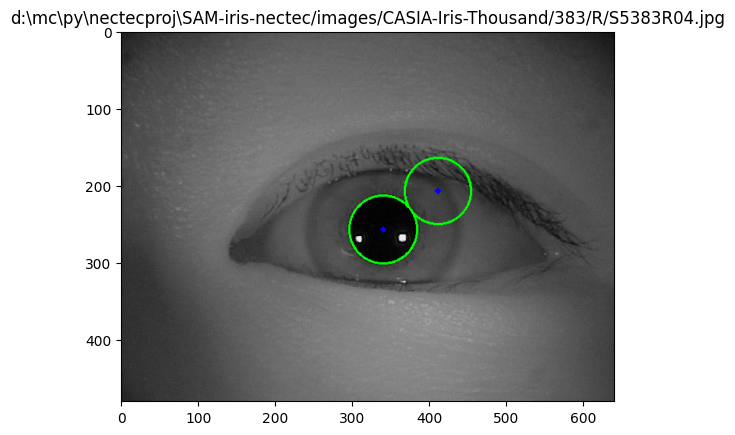

nan
nan


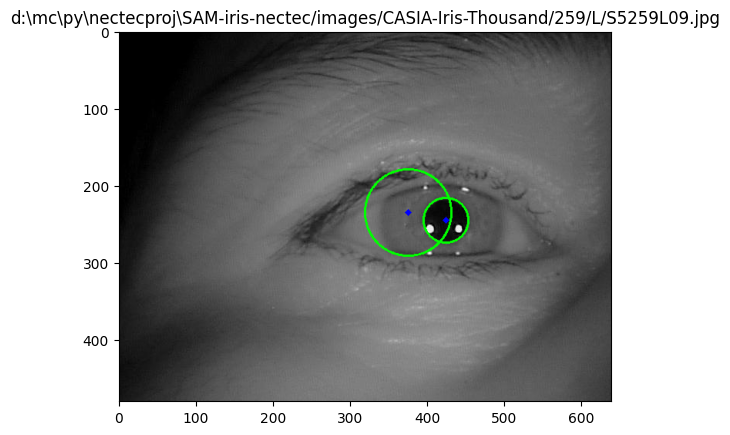

nan


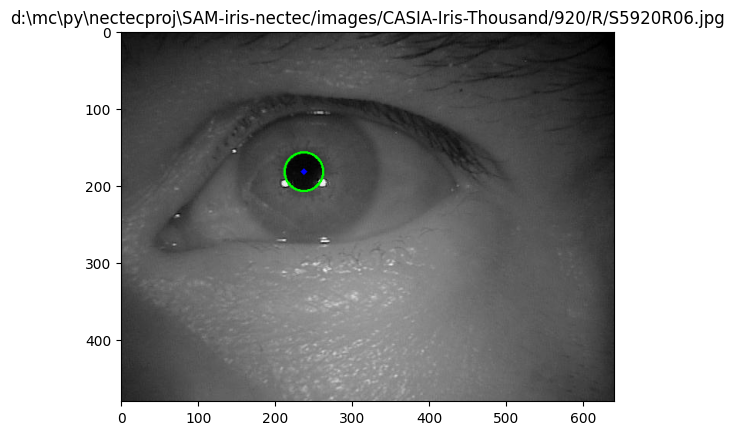

nan
nan
nan
nan


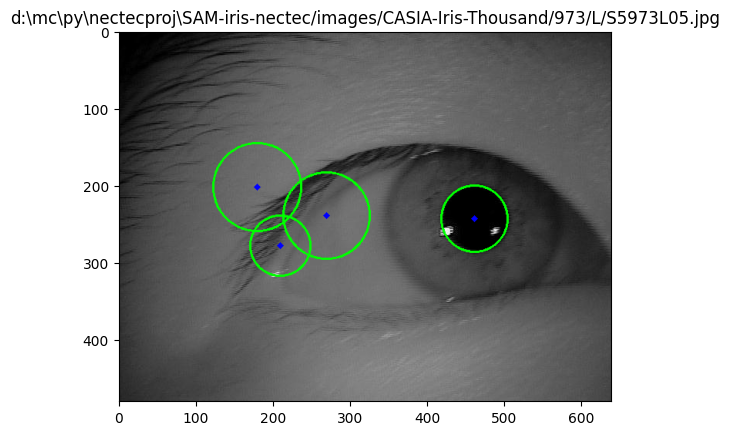

nan


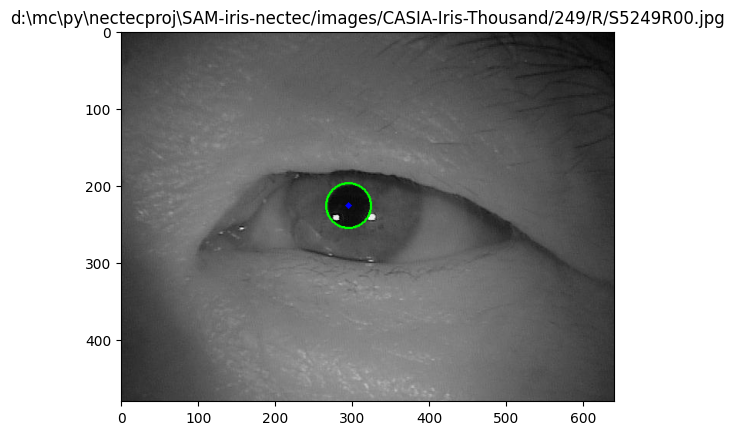

nan
nan
nan


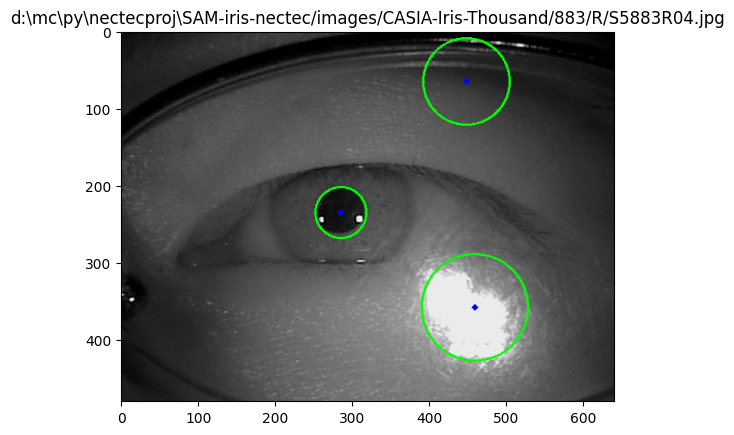

nan


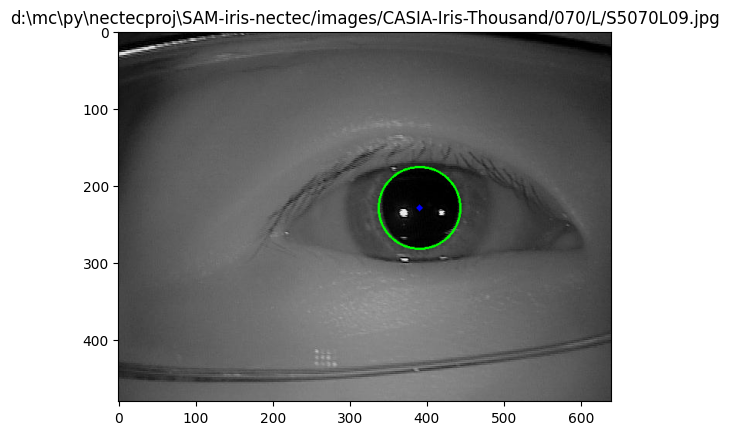

nan
nan
nan
nan
nan
nan
nan


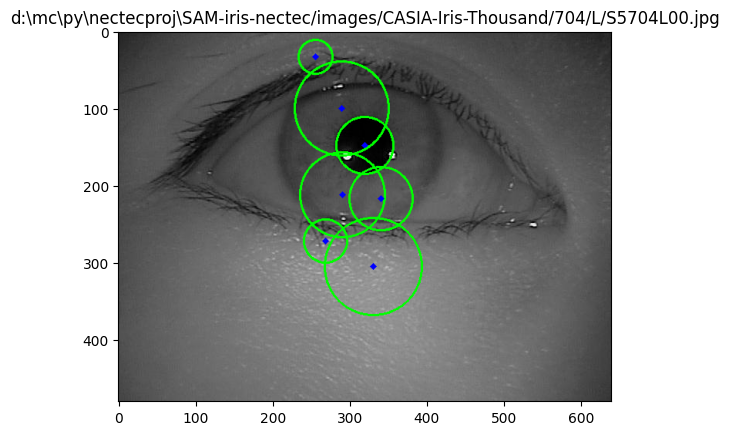

104.69074333800842
nan
nan
nan
nan


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [93]:

HOME_PATH = os.getcwd()
image_path = os.path.join(HOME_PATH, "images", "CASIA-Iris-Thousand","767","L","S5767L07.jpg")
pathList = randIrisPath("CASIA-Iris-Thousand",30)
raw_img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
preprocessed_img = preprocess_img(image_path)


for image_path in pathList:
    raw_img = cv2.imread(image_path)
    preprocessed_img = preprocess_img(image_path)

    circles=HoughTransform_Pupil(preprocessed_img)
    for c in circles[0,:]:
        # draw the outer circle
        cv2.circle(raw_img,(c[0],c[1]),c[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(raw_img,(c[0],c[1]),2,(0,0,255),3)
        
        print(average_pixel_value(raw_img, c))
 
    plt.imshow(raw_img)
    plt.title(image_path)
    plt.show()

    # for c in circles[0,:]:
    #     snake = ActiveContour_pupil(preprocessed_img,c)



In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

HOME_PATH = os.getcwd()
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = os.path.join(HOME_PATH, "weights", "sam_vit_h_4b8939.pth") #sam_iris.pt
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded


def widgetToBox(box):
  return np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
  ])
  

def showAnnotator(masks,scores,show_mask=[0,1,2],ann_mode="bbox"):
  if ann_mode == "bbox": annotator = sv.BoundingBoxAnnotator(color=sv.Color.RED,color_lookup=sv.ColorLookup.INDEX)
  elif ann_mode == "circle": annotator = sv.CircleAnnotator(color=sv.Color.RED,color_lookup=sv.ColorLookup.INDEX)

  mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=masks),
      mask=masks
  )

  mask_img = []
  titles = []
  for i in show_mask:
    mask_img.append(annotator.annotate(scene=img.copy(), detections=detections[i]))
    mask_img.append(mask_annotator.annotate(scene=img.copy(), detections=detections[i]))
    titles.append(f'Border of Mask {i}')
    titles.append(f'Mask {i} Score={scores[i]}')
  
  sv.plot_images_grid(
    images=mask_img,
    grid_size=(len(show_mask), 2),
    titles=titles
  )
  
  
def randIrisPath(dir:str, num:int)->list:
    base_path = f"{HOME_PATH}/images/{dir}"
    
    pathList = []
    
    for n in range(num):
        img_path = base_path
        cur_ls = os.listdir(base_path)
        while True:
            i = randint(0,len(cur_ls)-1)
            img_path+=f"/{cur_ls[i]}"
            
            if cur_ls[i].endswith('.jpg'):break
            
            cur_ls = os.listdir(img_path)
        pathList.append(img_path)
        
    return pathList


def maskPredict(point_coords, point_labels, mask_predictor,img):
  masks, scores, logits = mask_predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    multimask_output=True
  )

  mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=masks),
      mask=masks
  )
  mask1 = mask_annotator.annotate(scene=img.copy(), detections=detections[0])
  mask2 = mask_annotator.annotate(scene=img.copy(), detections=detections[1])
  mask3 = mask_annotator.annotate(scene=img.copy(), detections=detections[2])
  #print(detections)

  sv.plot_images_grid(
      images=[mask1, mask2, mask3],
      grid_size=(1, 3),
      titles=[
              f'Mask 1, Score={scores[0]}',
              f'Mask 2, Score={scores[1]}',
              f'Mask 3, Score={scores[2]}'
            ]
  )

## Set Image


(480, 640, 3)

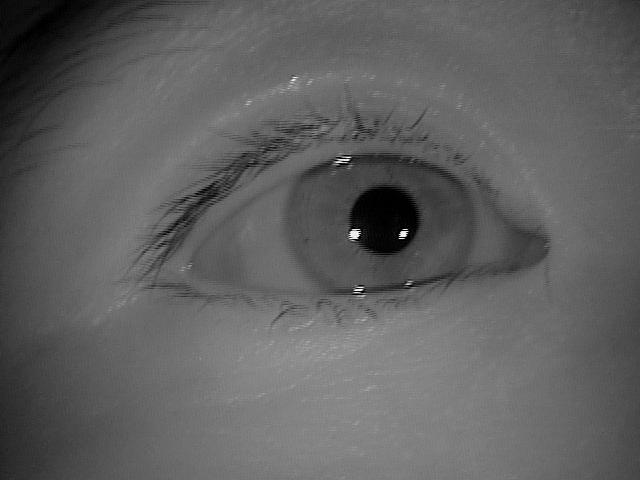

In [7]:
#Set image
image_path = os.path.join(HOME_PATH, "images", "CASIA-Iris-Thousand","116","L","S5116L01.jpg")
img = cv2.imread(image_path)

print(encode_image(image_path))
print(img.shape)

In [24]:
mask_predictor.set_image(img)

In [11]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(image_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

[378 212 394 229]
[386, 220]


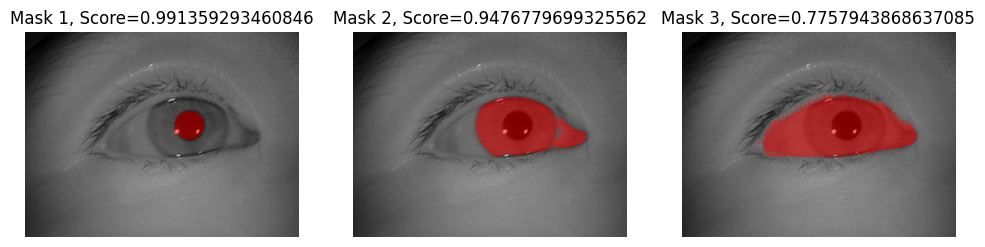

In [25]:
iris_box = widgetToBox(widget.bboxes[0])
print(iris_box)

init_point = [int((iris_box[0]+iris_box[2])/2),
              int((iris_box[1]+iris_box[3])/2)]

print(init_point)

point_coords = np.array([init_point])
point_labels=np.array([1])
maskPredict(point_coords, point_labels,mask_predictor,img)

